# 0. Prerequites

Install all required python package

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install powerlaw
!{sys.executable} -m pip install python-louvain
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install matplotlib

# 1. Import package

In [3]:
from networkx import nx
import matplotlib.pyplot as plt
import csv
import collections
import math
import powerlaw
import community
import warnings
warnings.filterwarnings("ignore")

# 2. Read data and build the network

In [4]:
def read(path, d):
    with open(path, newline='') as f:
        reader = csv.reader(f, delimiter=d)
        return [(row[0], row[1]) for row in reader]
    
data = read("Simple_pairwise-London_tube_map.txt", "\t")

# 3. Analyze the network

In [5]:
g = nx.Graph(data)
n, m = g.number_of_nodes(), g.number_of_edges()
p = m/((n - 1)*n/2)
diameter = nx.diameter(g)
c = nx.average_clustering(g)

degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

## 3.1.1 Describe the network a little. How many edges and nodes does it have? What is its diameter? And transitivity? And degree distribution?

In [6]:
print("************** Network Description **************")
print("Node size: {}\t\tEdge size: {}".format(n, m))
print("p:{:10.6f}".format(p))
print("diameter:{:10.6f}".format(diameter))
print("average shortest path length:{:10.6f}".format(nx.average_shortest_path_length(g)))
print("clustering coefficient:{:10.6f}".format(c))

************** Network Description **************
Node size: 359		Edge size: 417
p:  0.006489
diameter: 39.000000
average shortest path length: 14.053890
clustering coefficient:  0.024181


### Degree Histogram

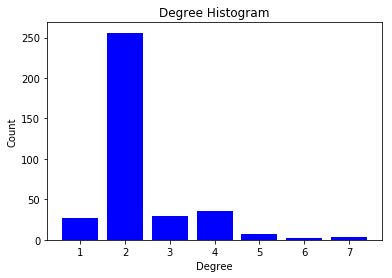

In [7]:
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)
plt.show()

# 3.1.2 Does it look like a random network?

In [8]:
print("**************** Real World Test ****************")
fit = powerlaw.Fit(degree_sequence, xmin=1)
print("Power Law test: alpha:{:10.6f}\t\tsigma:{:10.6f}".format(fit.alpha, fit.sigma))

print("{:<20}{}".format("Small diameter", math.log(n) > diameter))
print("{:<20}{}".format("High clustering", c > p))
print("{:<20}{}".format("Power law ", fit.alpha < 3))

**************** Real World Test ****************
Power Law test: alpha:  2.288988		sigma:  0.068030
Small diameter      False
High clustering     True
Power law           True


### Since we are dealing with subway network, so it's reasonable to have large diameter. We can see the network has the high clustering property if we compare the c and p. Also we see it's following power law distribution if we ignore all those initial stops (nodes with only 1 edge). So we can say it's highly possible a real world network based on analysis.

# 3.1.3 Apply a pagerank on the nodes and, if it is possible, visualize the network with node proportional to their pagerank.

******************* Page Rank *******************
Stratford                     :  0.006972
King''s_Cross_St_Pancras      :  0.006556
Baker_Street                  :  0.006199
Canning_Town                  :  0.005326
Willesden_Junction            :  0.005294
West_Ham                      :  0.005025
Green_Park                    :  0.004986
Turnham_Green                 :  0.004969
Oxford_Circus                 :  0.004952
Blackhorse_Road               :  0.004906


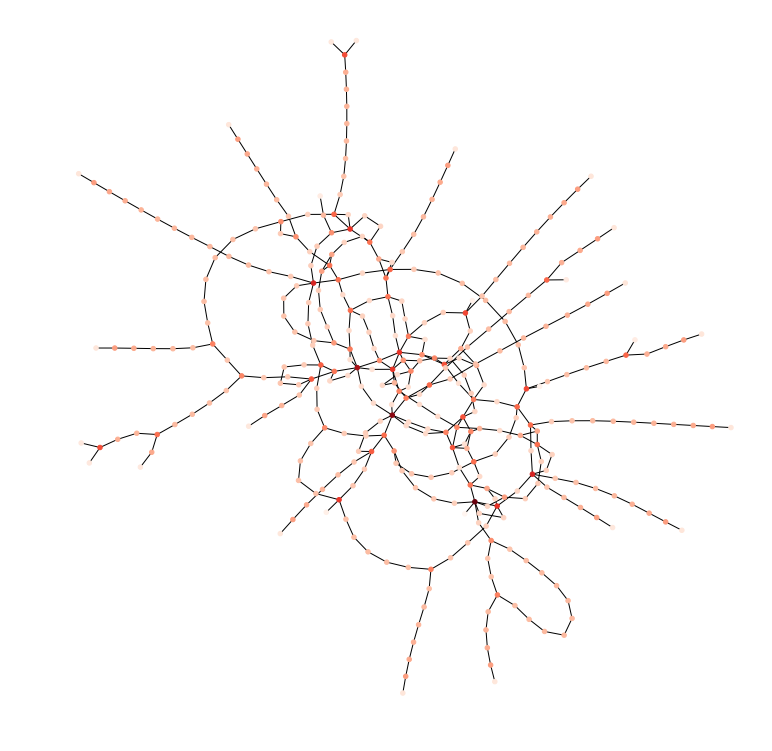

In [26]:
print("******************* Page Rank *******************")
pr = nx.pagerank(g)
max_color = max(pr.values())
color_list = [1 - value/max_color for value in pr.values()]
sorted_pr = sorted(pr.items(), key=lambda tup: (tup[1], tup[0]))
for key, value in reversed(sorted_pr[-10:]):
    print("{:<30}:{:10.6f}".format(key, value))

plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(g, node_size=20, node_color=color_list, cmap=plt.cm.Reds_r)
plt.show()

## 3.2.1 Now, use a community detection algorithm of your choice from the list provided. How many nodes does the largest community found contain?

In [27]:
print("************** Community Detection **************")
partition = community.best_partition(g)
partition_count = collections.Counter(list(partition.values()))
for i, count in sorted(partition_count.items(), key=lambda tup: tup[1], reverse=True):
    print("Group {:<3}\t{}".format(i+1, count))

************** Community Detection **************
Group 16 	31
Group 4  	30
Group 1  	28
Group 7  	27
Group 12 	26
Group 3  	25
Group 5  	23
Group 2  	22
Group 10 	22
Group 8  	21
Group 14 	20
Group 17 	19
Group 11 	14
Group 6  	13
Group 13 	13
Group 15 	13
Group 9  	12


## 3.2.2 Plot the histogram of community sizes

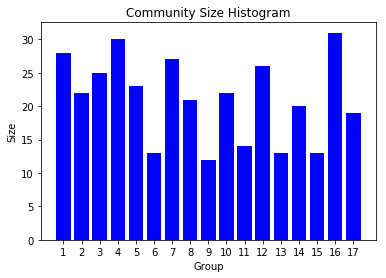

In [28]:
pos = nx.kamada_kawai_layout(g)
fig, ax = plt.subplots()
plt.bar(partition_count.keys(), partition_count.values(), width=0.80, color='b')
plt.title("Community Size Histogram")
plt.ylabel("Size")
plt.xlabel("Group")
ax.set_xticks([d for d in partition_count.keys()])
ax.set_xticklabels([c+1 for c in partition_count.keys()])
plt.show()

## 3.2.3 Plot the graph with its communities

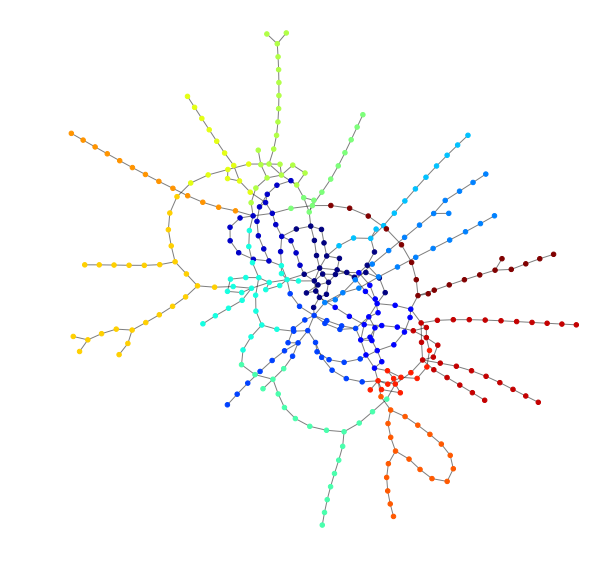

In [29]:
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_color=list(partition.values()), with_labels=False, node_size=20, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

## 4. Does the result make any sense, given that you know how you created the network?

#### Yes. Given the original London tube map has 14 lines and we got 17 groups identified, it's pretty close. 

#### If we compare the original tube map, we can see our community is detected in right way.
![Image of Yaktocat](http://www.bbc.co.uk/london/travel/downloads/tube_map.gif)

#### Also, the tops of PR which are Stratford, King''s_Cross_St_Pancras and Baker_Street are well selected. Given that we don't have a multigraph so we don't know if there is multiple line in the same station.